In [77]:
import numpy as np
from numpy import diff
import pandas as pa
import pylab as pl
from scipy.signal import hilbert, medfilt
from scipy import signal
import librosa
import matplotlib.pylab as plt
import sqlite3
import tqdm

In [2]:
ActualWeight = pa.read_excel("Seq2Seq/Actual_Weight_Urine_Stool_1736_1745.xlsx")
ActualWeight['Total Weight (g)'] = ActualWeight.iloc[:, 1:].sum(axis = 1)
ActualWeight

,ID,Actual Urine Weight (g),Actual Stool Weight (g),Total Weight (g)
0,1736,196.98,191.21,388.19
1,1737,199.95,208.36,408.31
2,1738,196.98,356.79,553.77
3,1739,197.10,318.63,515.73
4,1740,200.00,254.93,454.93
5,1741,200.50,330.66,531.16
6,1742,200.79,374.66,575.45
7,1743,197.14,431.00,628.14
8,1744,198.93,492.33,691.26
9,1745,198.47,305.82,504.29


# Plot to find patterns

In [10]:
def GetSpectrogramFeature(data_capture_id, sample_rate = 44100, hop_length = 44100):
    directory_name = "data/data_frames/data_capture_" + str(data_capture_id)
    if data_capture_id < 1780:
        wav_fn = directory_name + "/back_audio_data.wav"
        x, _ = librosa.load(wav_fn, sr = sample_rate)
    else:
        wav_fn = directory_name + "/audio_data.wav"
        x, _ = librosa.load(wav_fn, sr = sample_rate, mono = False)
        x = np.asfortranarray(x[0])
    
    S = librosa.feature.melspectrogram(y = x, sr = sample_rate, n_fft = 2048, n_mels = 128,
                                   fmax = 8000, hop_length=hop_length)
    X = librosa.power_to_db(S, ref=np.max)[::-1, :]
    return X

def PlotHighestFreqWithFiltered(data_capture_id, urine_regions, index = 0):
    X = GetSpectrogramFeature(data_capture_id)
    fig, axes = plt.subplots(2, 1, figsize = (10, 4), sharex = True)
    
    axes[0].plot(X[index])
    axes[1].plot(medfilt(X[index], 5))
    
    for region in urine_regions:
        axes[0].axvspan(region[0], region[1]+1, alpha=0.5, color='orange')
        axes[1].axvspan(region[0], region[1]+1, alpha=0.5, color='orange')
    plt.suptitle(data_capture_id)
    plt.show()

def ApplyEnvelope(sz):
    analytic_signal = hilbert(sz)
    env_sz = pa.Series(np.abs(analytic_signal))
    #env_sz.index = sz.index
    return env_sz

In [75]:
def GetUrinationStartEndTimes(data_capture_id, filter_window_size, threshold, extension_time):
    highestFreq = GetSpectrogramFeature(data_capture_id)[0]
    highestFreq = pa.Series(medfilt(highestFreq, filter_window_size))
    highestFreqAboveThreshold = GetValuesAboveThreshold(highestFreq, threshold)
    highestFreqAboveThreshold = RightExtendBooleanTrueValues(highestFreqAboveThreshold, extension_time)
    highestFreqAboveThreshold = LeftExtendBooleanTrueValues(highestFreqAboveThreshold, extension_time)
    urinationStartEndTimes = GetStartEndTimesOfBooleanSz(highestFreqAboveThreshold)
    return urinationStartEndTimes

def GetUrinationWeightLoss(data_capture_id, filter_window_size = 5, threshold = -60, extension_time = 3):
    urinationStartEndTimes = GetUrinationStartEndTimes(data_capture_id, filter_window_size, threshold, extension_time)
    #print ("{} : start-end-times {}".format(data_capture_id, urinationStartEndTimes))
    urinationWeightLoss = 0
    
    total_weight_sz = GetTotalWeight(data_capture_id)
    total_weight_filt_sz = ApplyMedianFilter(total_weight_sz, filter_window_size)
    
    for start_end in urinationStartEndTimes:
        weightLoss = GetWeightChange(total_weight_filt_sz, start_end[0], start_end[1])
        if weightLoss > 0:
            urinationWeightLoss += weightLoss
    return urinationWeightLoss

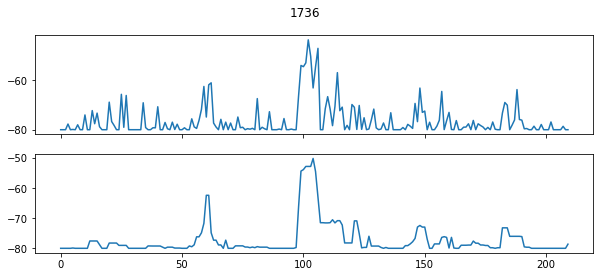

In [111]:
PlotHighestFreqWithFiltered(1736, [], index = 0)

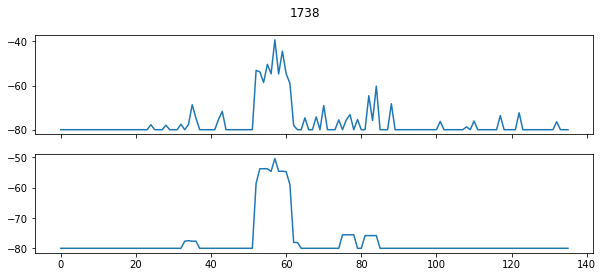

In [114]:
PlotHighestFreqWithFiltered(1738, urine_regions = [], index = 0)

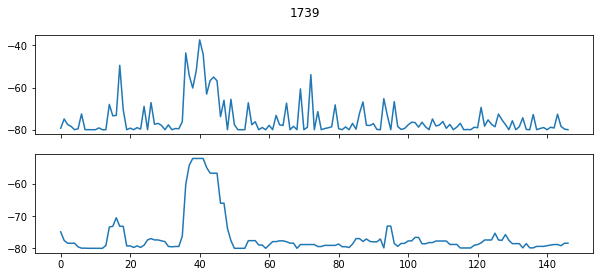

In [115]:
PlotHighestFreqWithFiltered(1739, urine_regions = [], index = 0)

In [100]:
data_capture_ids = [1736, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745]
res = []
for data_capture_id in data_capture_ids:
    predicted = GetUrinationWeightLoss(data_capture_id, filter_window_size = 11, threshold = -65, extension_time = 1)
    actual = ActualWeight[ActualWeight.ID == data_capture_id].iloc[:, 1].values[0]/1000
    res.append([predicted, actual, predicted - actual])

In [101]:
resDF = pa.DataFrame(1000 * np.array(res))
resDF.columns = ["Predicted Urine (g)", "Actual Urine (g)", "Error (g)"]
resDF.index = data_capture_ids
resDF.round(1)

,Predicted Urine (g),Actual Urine (g),Error (g)
1736,174.5,197.0,-22.5
1738,171.8,197.0,-25.1
1739,161.2,197.1,-35.9
1740,139.0,200.0,-61.0
1741,191.3,200.5,-9.2
1742,205.0,200.8,4.2
1743,195.0,197.1,-2.1
1744,193.2,198.9,-5.8
1745,195.2,198.5,-3.3


# Look at cases

In [108]:
def PlotMedianFiltedWithPredictedRegions(data_capture_id):
    urineRegions = GetUrinationStartEndTimes(data_capture_id, filter_window_size = 11, threshold = -65, extension_time = 1.5)
    
    plt.figure(figsize = (10, 2))
    X = GetSpectrogramFeature(data_capture_id)
    
    plt.plot(medfilt(X[0], 5))
    for region in urineRegions:
        plt.axvspan(region[0], region[1]+1, alpha=0.5, color='orange')
    plt.suptitle(data_capture_id)
    plt.show()

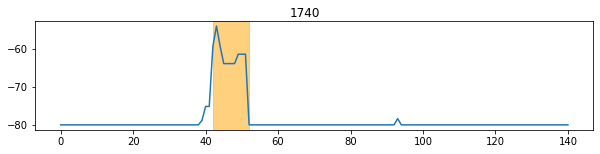

In [109]:
PlotMedianFiltedWithPredictedRegions(1740)

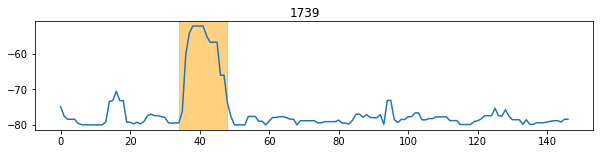

In [110]:
PlotMedianFiltedWithPredictedRegions(1739)

# Helper function

In [3]:
def GetSensor(use_i,sensor_i):
    sql_s = "SELECT timestamp_ms, value FROM data WHERE data_capture_id={} AND sensor_id={}".format(use_i,sensor_i)
    conn = sqlite3.connect('data/toilet.db')
    cursor = conn.execute(sql_s)
    time_measurements = []
    distance_measurements = []
    for row in cursor:
        time_measurements.append(row[0])
        distance_measurements.append(row[1])
    #endfor
    data_t = (time_measurements,distance_measurements)
    return data_t
#enddef

def cleanSensors(sensor1_t_l,sensor1_y_l,sensor2_t_l,sensor2_y_l):
    
    min_t = min(min(sensor1_t_l),min(sensor2_t_l))
    max_t = max(max(sensor1_t_l),max(sensor2_t_l))

    # setup partitions
    step_t = 500
    min_floor_t = int(np.floor(min_t/step_t)*step_t)
    max_ceil_t = int(np.ceil(max_t/step_t)*step_t)
    
    step1_d = {}
    step2_d = {}
    for i in range(min_floor_t,max_ceil_t+step_t,step_t):
        step1_d[i] = []
        step2_d[i] = []
    #endfor

    # step through both and assign values to each partition
    for i in range(len(sensor1_t_l)):
        interval_t = int(np.floor(sensor1_t_l[i]/step_t)*step_t)
        step1_d[interval_t].append(sensor1_y_l[i])
    #endfor
    for i in range(len(sensor2_t_l)):
        interval_t = int(np.floor(sensor2_t_l[i]/step_t)*step_t)
        step2_d[interval_t].append(sensor2_y_l[i])
    #endfor

    # step through each partition and either take averages or set to nan
    clean1_d = {}
    for i in step1_d.keys():
        if(len(step1_d[i]) > 0):
            clean1_d[i] = np.mean(step1_d[i])
    #endfor
    clean1_sz = pa.Series(clean1_d)

    clean2_d = {}
    for i in step2_d.keys():
        if(len(step2_d[i]) > 0):
            clean2_d[i] = np.mean(step2_d[i])
    #endfor
    clean2_sz = pa.Series(clean2_d)
    
    return clean1_sz, clean2_sz

def GetTotalWeight(data_capture_id):
    data_d = {}
    data_d[2] = GetSensor(data_capture_id, 2) # seat scale
    data_d[3] = GetSensor(data_capture_id, 3) # foot scale
    
    #t0 = data_d[2][0][0]
    
    clean1_sz, clean2_sz = cleanSensors(data_d[2][0],data_d[2][1],data_d[3][0],data_d[3][1])
    seatScale_sz = clean1_sz/1000
    footScale_sz = clean2_sz/1000
    sumScale_sz = seatScale_sz  + footScale_sz
    #sumScaleFiltered_sz = pd.Series(signal.medfilt(sumScale_sz, 11))
        
    sumScale_sz.index = (sumScale_sz.index - sumScale_sz.index[0])/1000
    #x_ix = sumScale_sz.index
    return sumScale_sz

def GetRadarSum(data_capture_id):

    data_fn = 'data/data_frames/data_capture_{}/radar_data.txt'.format(data_capture_id)
    data_f = open(data_fn,'rt')
    line_s = data_f.read()
    data_l = eval(line_s)

    # save array of images
    t0_sz = pa.Series(data_l[0]['data'])
    data_d = {}
    for j in range(len(data_l)):
        t = data_l[j]['timestamp_ms']
        j_sz = pa.Series(data_l[j]['data'][0])
        data_d[t] = j_sz
    #endfor
    data_df = pa.DataFrame(data_d)
    
    area_d = {}
    floor_i = 50
    ceil_i = 200
    for i in data_df.columns:
        sq_sz = (data_df[i])**2
        area_d[i] = sum(sq_sz.iloc[floor_i:ceil_i])
    #endfor
    area_sz = pa.Series(area_d)
    area_sz = area_sz / 1e9
    area_sz = area_sz - area_sz.median()
    t0 = data_l[0]['timestamp_ms']
    area_sz.index = (area_sz.index-t0)/1000 #
    
    return area_sz

In [42]:
def RightExtendBooleanTrueValues(sz, extension_time):
    temp_sz = sz.copy()
    i = 1
    while i < len(temp_sz):
        if((temp_sz.values[i-1] == True) and (temp_sz.values[i] == False)):
            extension_end_time = temp_sz.index[i] + extension_time
            while (i < len(temp_sz)) and (temp_sz.index[i] < extension_end_time):
                temp_sz.values[i] = True
                i += 1
        i += 1
    return temp_sz

def LeftExtendBooleanTrueValues(sz, extension_time):
    temp_sz = sz.copy()
    i = len(temp_sz) - 2
    while i >= 0:
        if((temp_sz.values[i] == False) and (temp_sz.values[i+1] == True)):
            extension_end_time = temp_sz.index[i] - extension_time
            while (i >= 0) and (temp_sz.index[i] > extension_end_time):
                temp_sz.values[i] = True
                i -= 1
        i -= 1
    return temp_sz

def GetValuesAboveThreshold(sz, threshold):
    return sz > threshold

def GetStartEndTimesOfBooleanSz(sz):
    ts = sz.index
    start_end_times = []
    
    i = 0
    while i < len(sz):
        if sz.values[i] == True:
            j = i
            while (j < len(sz)-1) and (sz.values[j+1] == True):
                j += 1
            start_end_times.append([ts[i], ts[j]])
            i = j + 1
        else:
            i += 1

    return start_end_times

def ApplyMedianFilter(sz, window_size):
    filt_sz = pa.Series(signal.medfilt(sz, window_size))
    filt_sz.index = sz.index
    return filt_sz

def GetWeightChange(weight_sz, start_time, end_time):
    start_idx = (pa.Series(weight_sz.index) > start_time).idxmax() - 1
    end_idx = (pa.Series(weight_sz.index) > end_time).idxmax()
    #print("Weight at start time: {}".format(weight_sz.iloc[start_idx]))
    #print("Weight at end time: {}".format(weight_sz.iloc[end_idx]))
    return weight_sz.iloc[start_idx] - weight_sz.iloc[end_idx]